# Package imports

In [38]:
import numpy as np
from skimage.transform import resize
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Layer, InputSpec
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize


import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%run ../src/layers/dropblock.py
%run ../src/layers/adabound.py
%run ../src/layers/extra_layers.py
%run ../src/layers/convgru.py

<Figure size 432x288 with 0 Axes>

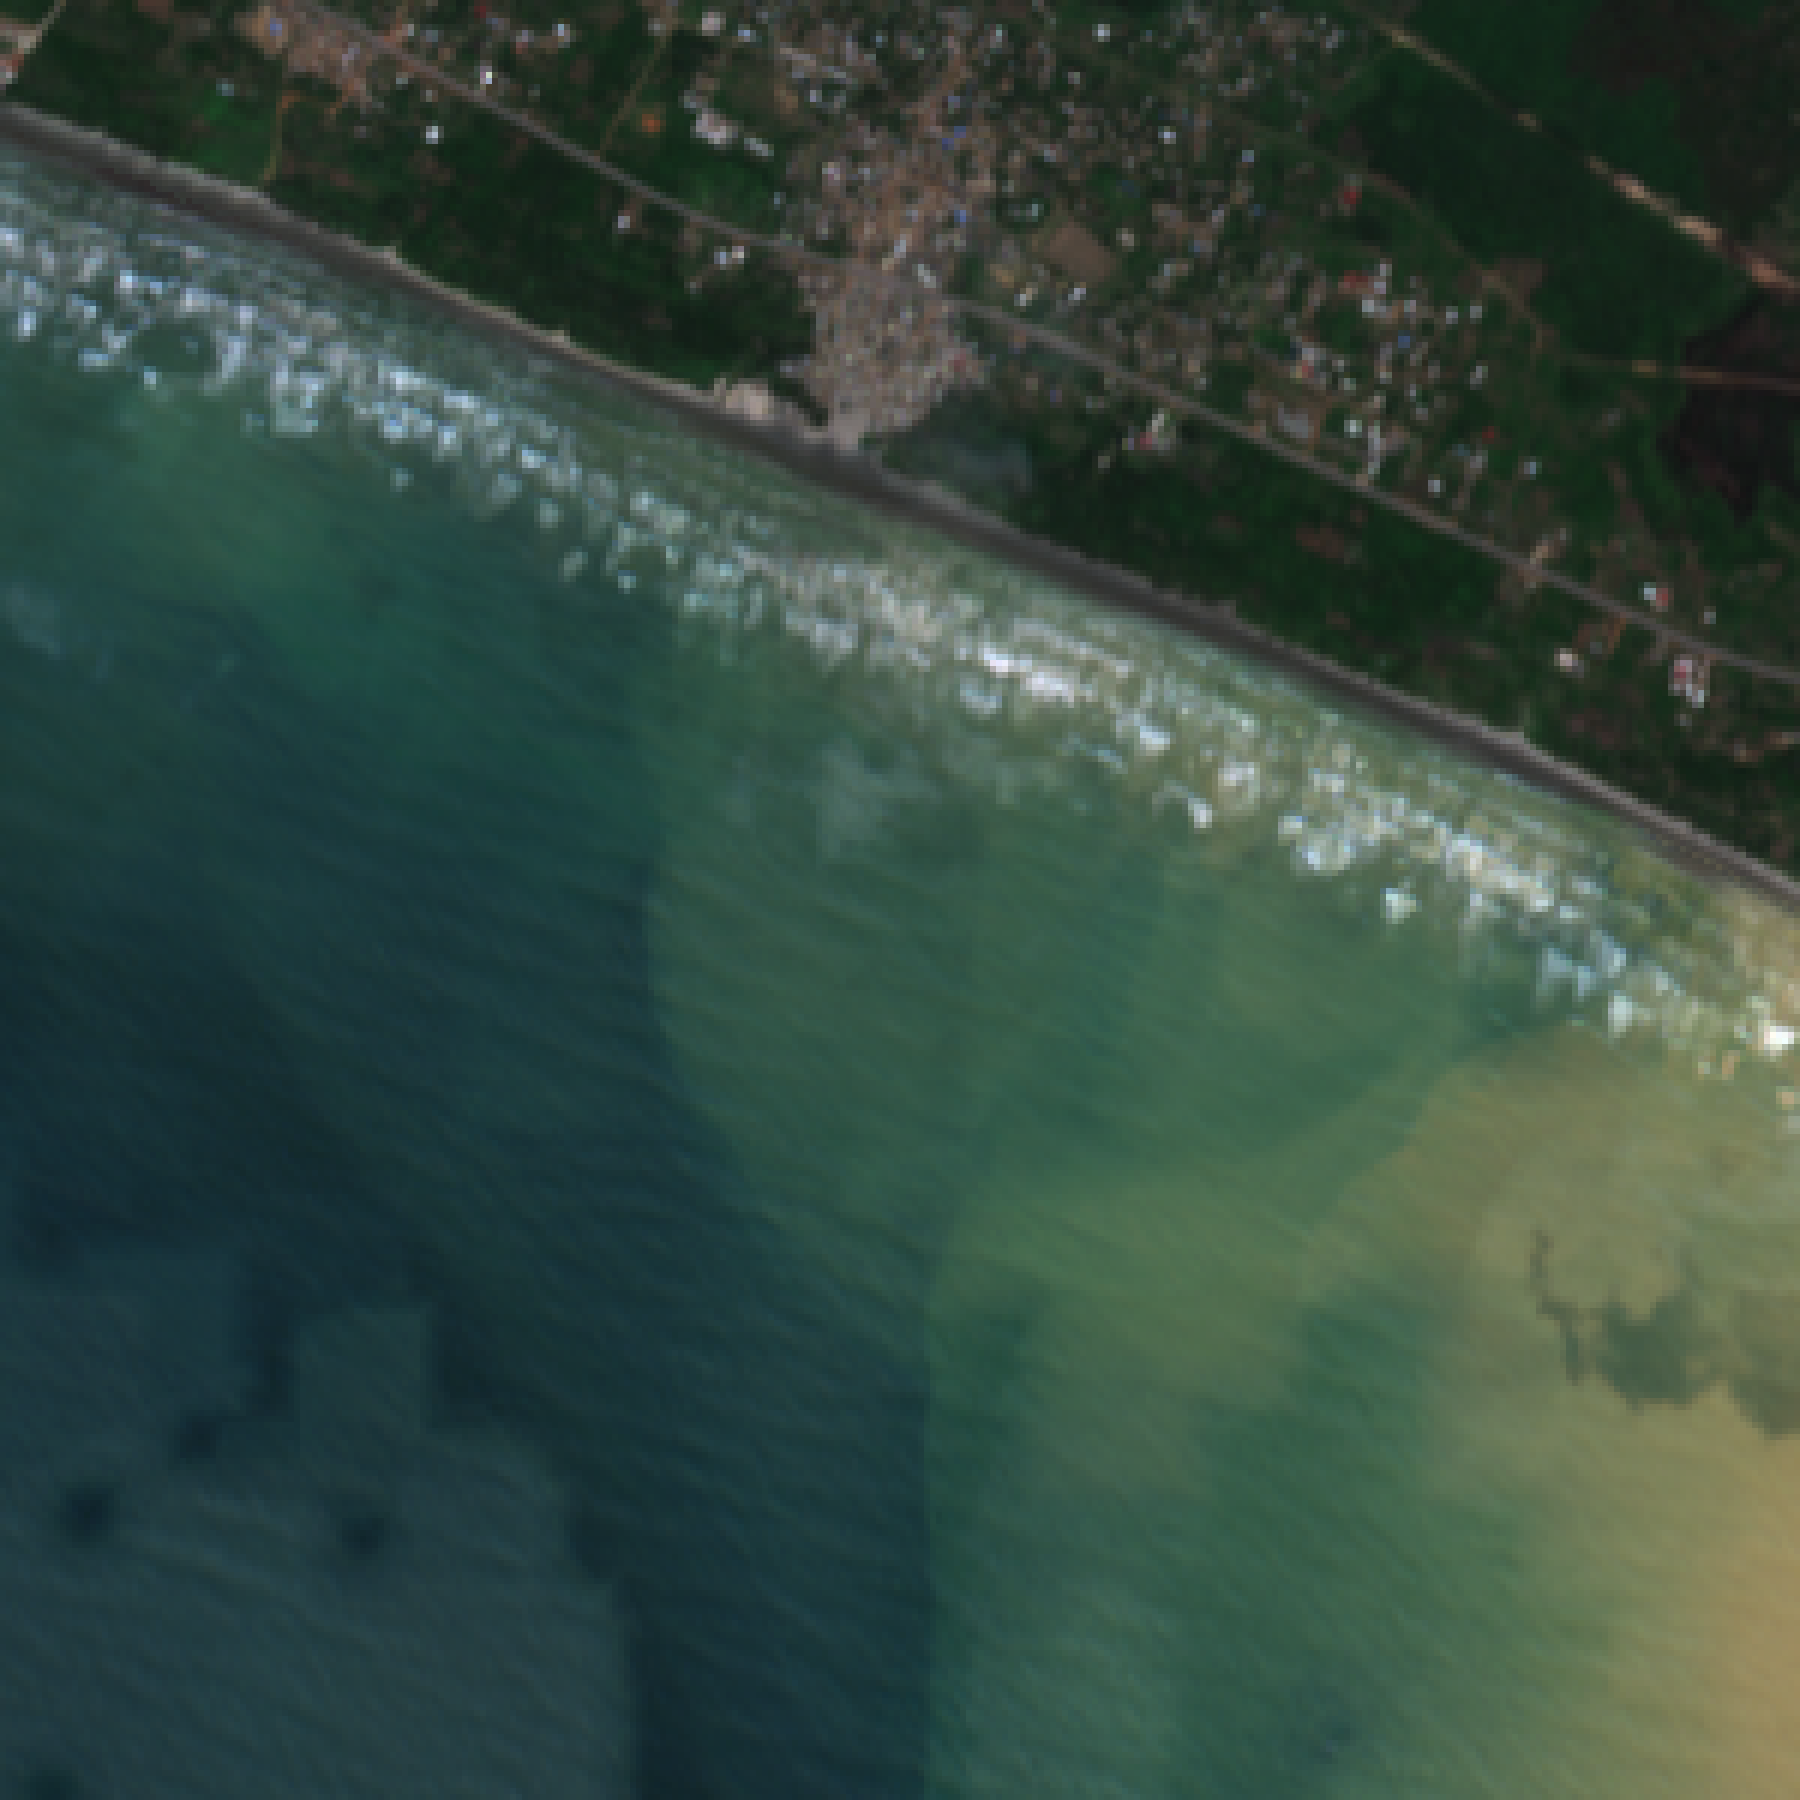

<Figure size 864x720 with 0 Axes>

In [61]:
from PIL import Image
from IPython.display import display
from skimage.transform import resize

def arr_to_rgb(arr):
    l = np.copy(arr)
    l_red = np.copy(l[..., 2])
    l_blue = np.copy(l[..., 0])
    l[..., 0] = l_red
    l[..., 2] = l_blue

    maxes = np.array(np.max(l, axis = (0, 1)))
    l = l / maxes
    l = Image.fromarray((l * 255).astype(np.uint8), 'RGB')
    return l, maxes

x = np.load("../src/s2_median.npy")
l, m = arr_to_rgb(x[-300:, -300:, :3], None)
l = (l.resize(( int(l.width * 6), int(l.height * 6)), 0))
display(l)

# Util functions

In [2]:
def make_input_data(idx, cropping = True, histmatch = True, train = True):
    
    # Load 5, 10 meter imagery and standardize to 0-1, float32
    out = np.load(f"../data/supres/numpy-allbands/{idx}_05m.npy")
    out = out.swapaxes(1, 3)
    out = out.swapaxes(1, 2)
    out = out / 10000
    
    out2 = np.load(f"../data/supres/numpy-allbands/{idx}_05m-2.npy")
    out2 = out2.swapaxes(1, 3)
    out2 = out2.swapaxes(1, 2)
    out2 = out2 / 10000
    
    out = np.concatenate([out, out2], axis = -1)
    
    inp = np.load(f"../data/supres/numpy-allbands/{idx}_10m.npy")
    inp = inp.swapaxes(1, 3)
    inp = inp.swapaxes(1, 2)
    inp = inp / 10000
    
    inp2 = np.load(f"../data/supres/numpy-allbands/{idx}_20m.npy")
    inp2 = inp2.swapaxes(1, 3)
    inp2 = inp2.swapaxes(1, 2)
    inp2 = inp2 / 10000
    inp2 = inp2.repeat(2, axis = 1).repeat(2, axis = 2)
    inp = np.concatenate([inp, inp2], axis = -1)
    
    print(out.shape, inp.shape)
    
    # Match the histogram between Sentinel-2, VeNuS
    if histmatch:
        std_src = np.std(inp, axis = (1, 2))
        std_ref = np.std(out, axis = (1, 2))
        
        mean_src = np.mean(inp, axis = (1, 2))
        mean_ref = np.mean(out, axis = (1, 2))
        std_mult = std_ref / std_src
        
        addition = (mean_ref - (mean_src * std_mult))
        #print(std_mult[2], addition[2])
        inp = inp * (std_mult[:, np.newaxis, np.newaxis]) + addition[:, np.newaxis, np.newaxis]
        inp = np.clip(inp, 0, 1)
        
    # Crop images to 128x128 for training purposes
    if cropping:
        shuffler = np.random.permutation(len(inp))
        inp = inp[shuffler]
        out = out[shuffler]
        start_x = 0
        start_y = 0
        start_x = np.random.randint(0, 64, 1)[0]
        start_y = np.random.randint(0, 64, 1)[0]
        out = out[:, start_x*2:start_x*2+128, start_y*2:start_y*2 + 128]
        inp = inp[:, start_x:start_x+64, start_y:start_y + 64]
        
    if train:
        inp = inp.reshape((inp.shape[0], inp.shape[1] // 2, 2, inp.shape[2] // 2, 2, 8))
        inp = np.mean(inp, axis = (2,4 ))
    #print(out.shape, inp.shape)
    return np.float32(inp), np.float32(out)


In [3]:
def make_input_data(idx):
    i = np.load(f"../src/feats_{str(idx)}.npy")
    i = i[:, :216, :216]
    print(i.shape)
    inp = np.copy(i)
    inp = np.reshape(i, (54, 4, 54, 4, 32))
    inp = np.mean(inp, axis = (1, 3))
    return inp, i
l, i = make_input_data(23)
print(l.shape)
print(i.shape)

(1, 216, 216, 32)
(54, 54, 32)
(1, 216, 216, 32)


# Layer functions

In [4]:
# NOT USED
class ICNR:
    """ICNR initializer for checkerboard artifact free sub pixel convolution
    Ref:
     [1] Andrew Aitken et al. Checkerboard artifact free sub-pixel convolution
     https://arxiv.org/pdf/1707.02937.pdf)
    Args:
    initializer: initializer used for sub kernels (orthogonal, glorot uniform, etc.)
    scale: scale factor of sub pixel convolution
    """

    def __init__(self, initializer, scale=1):
        self.scale = scale
        self.initializer = initializer

    def __call__(self, shape, dtype, partition_info=None):
        shape = list(shape)
        if self.scale == 1:
            return self.initializer(shape)

        new_shape = shape[:3] + [shape[3] // (self.scale ** 2)]
        x = self.initializer(new_shape, dtype, partition_info)
        x = tf.transpose(x, perm=[2, 0, 1, 3])
        x = tf.image.resize_nearest_neighbor(x, size=(shape[0] * self.scale, shape[1] * self.scale))
        x = tf.space_to_depth(x, block_size=self.scale)
        x = tf.transpose(x, perm=[1, 2, 0, 3])

        return x

## ESA

In [5]:
def esa(inp, esa_channels, n_feats, scope):
    c1_ = Conv2D(esa_channels, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='linear', strides=(1, 1),
                  name=scope + "_conv")(inp)
    
    c1 = Conv2D(esa_channels, (3, 3), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='linear', strides=(2, 2),
                  name=scope + "_conv1")(c1_)

    vmax = tf.compat.v1.layers.MaxPooling2D(pool_size=2, strides=2)(c1)

    c3 = Conv2D(esa_channels, (3, 3), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='linear', strides=(1, 1),
                  name=scope + "_conv2")(vmax)
    
    c3 = tf.keras.layers.UpSampling2D(
        size=(4, 4), interpolation='bilinear')(c3)
    
    cf = Conv2D(esa_channels, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='linear', strides=(1, 1),
                  name=scope + "_conv3")(c1_)
    
    c4 = c3 + cf
    c4 = Conv2D(n_feats, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='sigmoid', strides=(1, 1),
                  name=scope + "_conv4")(c4)
    return inp * c4


In [6]:
def pixelattention(inp, feats, scope):
    y = Conv2D(filters = feats, kernel_size = (1, 1),  strides = 1,
                      activation = None, padding = 'valid', use_bias = True,
                      kernel_initializer = tf.keras.initializers.he_uniform())(inp)
    y = tf.nn.sigmoid(y)
    y = tf.multiply(inp, y)
    return y


def paconv(inp, feats):
    y = Conv2D(filters = feats, kernel_size = (1, 1),  strides = 1,
                      activation = None, padding = 'valid', use_bias = True,
                      kernel_initializer = tf.keras.initializers.he_uniform())(inp)
    y = tf.nn.sigmoid(y)
    
    out = Conv2D(filters = feats, kernel_size = (3, 3),  strides = 1,
                      activation = None, padding = 'same', use_bias = False,
                      kernel_initializer = tf.keras.initializers.he_uniform())(inp)
    #out = tf.nn.swish(out) # TEST
    out = tf.multiply(out, y)
    out = Conv2D(filters = feats, kernel_size = (3, 3),  strides = 1,
                      activation = None, padding = 'same', use_bias = False,
                      kernel_initializer = tf.keras.initializers.he_uniform())(out)
    #out = tf.nn.swish(out) # TEST
    return out

def spca(inp, feats, reduction):
    group_width = feats // reduction
    out_a = Conv2D(kernel_size = 1, filters = group_width, padding = 'same',
                   use_bias = False, activation = None)(inp)
    out_a = tf.nn.swish(out_a)
    out_b = Conv2D(kernel_size = 1, filters = group_width, padding = 'same',
                   use_bias = False, activation = None)(inp)
    out_b = tf.nn.swish(out_b)
    
    out_b = paconv(out_b, group_width)
    out_b = tf.nn.swish(out_b)
    
    out_a = Conv2D(kernel_size = 3, filters = group_width, padding = 'same',
                   use_bias = False, activation = None)(out_a)
    out_a = tf.nn.swish(out_a)
    
    out = Conv2D(kernel_size = 1, filters = feats, padding = 'valid',
                   use_bias = False, activation = None)(tf.concat([out_a, out_b], axis = -1))
    out = out + inp
    return out

In [7]:
def conv_relu(inp, 
                 is_training, 
                 scope,
                 kernel_size,
                 filters, 
                 stride = (1, 1),
                 activation = True,
                 use_bias = True):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.
          
    '''

    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
                      activation = None, padding = 'valid', use_bias = use_bias,
                      kernel_initializer = tf.keras.initializers.he_uniform())(inp)
    if activation:
        conv = tf.nn.relu(conv)
    return conv

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [8]:
def conv_swish_gn(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 norm = True,
                 dropblock = True,
                 csse = True,
                 weight_decay = None,
                 block_size = 5,
                 padding = "VALID",
                 partial = False):
    '''2D convolution, group normalization, SWISH activation, drop block, SSE. 
       DropBlock performs best when applied last, according to original paper.
       This is the core CONV block for this model.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          keep_rate (float): Keep rate for dropblock
          stride (tuple): Conv2D stride parameter
          activation (bool): Whether or not to apply Swish activation
          use_bias (bool): whether to use bias. Should always be false
          norm (bool): whether or not to apply group normalization
          dropblock (bool): whether or not to apply dropblock
          csse (bool): whether or not to apply SSE block
          weight_decay (bool): not currently implemented
          block_size (int): Block size for dropblock
          padding (str): padding parameter for conv2d
          partial (bool): Whether or not to use partial conv or Conv2D

         Returns:
          conv (tf.Variable): output of the block
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    gn_flag = "Group Norm" if norm else ""
    activation_flag = "RELU" if activation else "Linear"
    sse_flag = "SSE" if csse else "No SSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
        
    print(f"{scope} Conv: Kernel: {kernel_size}, {gn_flag}, {activation_flag}, {sse_flag}, {drop_flag}")

    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, 
                      kernel_size = (kernel_size, kernel_size), 
                      strides = stride,
                      activation = None,
                      padding = 'valid',
                      use_bias = use_bias,
                      kernel_initializer = tf.keras.initializers.he_normal()
                     )(inp)
       
    
    if norm:
        conv = group_norm(x = conv, scope = scope, G = 4)
    if activation:
        conv = tf.nn.swish(conv)
    #if csse:
        #conv = esa(conv, "csse_" + scope, esa_channels = 16, n_feats = filters)
       # conv = sse_block(conv, "csse_" + scope)
    return conv


def resblock2(inp, is_training, scope, filters):
    inp_pad = ReflectionPadding2D()(inp)
    conv = conv_swish_gn(inp = inp_pad, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = scope + "1", filters = filters,
            keep_rate = 1., activation = True, use_bias = True, norm = False,
            csse = False, dropblock = False, weight_decay = None)
    
    conv_pad = ReflectionPadding2D()(conv)
    conv2 =  conv_swish_gn(inp = conv_pad, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = scope + "2", filters = filters,
            keep_rate = 1., activation = False, use_bias = True, norm = False,
            csse = False, dropblock = False, weight_decay = None)

    add = tf.add(inp, conv2)
    #add = esa(conv, scope = "csse_" + scope, esa_channels = 16, n_feats = filters)
    
    return add
    

# Graph creation

In [9]:
input_ = tf.placeholder(tf.float32, shape=(None, None, None, 32))
bilinear_input = tf.placeholder(tf.float32, shape = (None, None, None, 32))
labels =  tf.placeholder(tf.float32, shape = (None, None, None, 32))
is_training = tf.placeholder_with_default(False, (), 'is_training')

depth = 2
width = 40

In [10]:
"""

# BLOCK
outconv = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(conv)
outconv = ReflectionPadding2D()(outconv)
outconv = conv_swish_gn(inp = outconv, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = 40, 
                    keep_rate = 1., activation = True, use_bias = True, norm = False,
                    csse = False, dropblock = False, weight_decay = None)
#outconv = pixelattention(outconv,40, 'up2pa')
# END BLOCK
"""


"""
# Upsample ICNR + Average pooling + pixel attention
outconv = Conv2D(filters = width * 4, 
                      kernel_size = (3, 3), 
                      strides = 1,
                      activation = None,
                      padding = 'same',
                      use_bias = True,
                      kernel_initializer = ICNR(tf.keras.initializers.glorot_uniform(), 1)
                     )(conv)
#outconv = tf.nn.swish(outconv)
outconv = tf.nn.depth_to_space(outconv, 2)
outconv = pixelattention(outconv, width, 'up2pa')
"""

"\n# Upsample ICNR + Average pooling + pixel attention\noutconv = Conv2D(filters = width * 4, \n                      kernel_size = (3, 3), \n                      strides = 1,\n                      activation = None,\n                      padding = 'same',\n                      use_bias = True,\n                      kernel_initializer = ICNR(tf.keras.initializers.glorot_uniform(), 1)\n                     )(conv)\n#outconv = tf.nn.swish(outconv)\noutconv = tf.nn.depth_to_space(outconv, 2)\noutconv = pixelattention(outconv, width, 'up2pa')\n"

In [11]:
# Shallow feature extraction
inp_pad = ReflectionPadding2D()(input_)
feats = conv_relu(inp_pad, is_training, "in", 3, width, activation = False, use_bias = True)


# 4-blocks of SPCA
conv = resblock2(feats, is_training, str(99), width)
conv = spca(conv, width, 2)
for d in range(depth - 1):
    conv = resblock2(conv, is_training, str(d), width)
    conv = spca(conv, width, 2)
    print(d, conv.shape)
    
conv = ReflectionPadding2D()(conv)
conv = conv_relu(conv, is_training, "out", 3, width, activation = False)

conv = conv + feats
#conv = pixelattention(conv, width, 'pa1')

# 1 - 2, Upsample2D, Conv, Swish, Pixel attention, Conv, Swish
outconv = tf.keras.layers.UpSampling2D(
        size=(2, 2), interpolation='nearest')(conv)

outconv = ReflectionPadding2D()(outconv)
outconv = conv_swish_gn(inp = outconv, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up4', filters = width, 
                    keep_rate = 1., activation = False, use_bias = True, norm = False,
               csse = False, dropblock = False, weight_decay = None)
outconv = pixelattention(outconv, width, 'up2pa')
outconv = tf.nn.swish(outconv)



outconv = ReflectionPadding2D()(outconv)
outconv = conv_swish_gn(inp = outconv, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up5', filters = width, 
                    keep_rate = 1., activation = False, use_bias = True, norm = False,
               csse = False, dropblock = False, weight_decay = None)
outconv = tf.nn.swish(outconv)


# 2 - 4, Upsample2D, Conv, Swish, Pixel attention, Conv, Swish
outconv = tf.keras.layers.UpSampling2D(
        size=(2, 2), interpolation='nearest')(outconv)

outconv = ReflectionPadding2D()(outconv)
outconv = conv_swish_gn(inp = outconv, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up6', filters = width, 
                    keep_rate = 1., activation = False, use_bias = True, norm = False,
               csse = False, dropblock = False, weight_decay = None)
outconv = pixelattention(outconv, width, 'up3pa')
outconv = tf.nn.swish(outconv)


outconv = ReflectionPadding2D()(outconv)
outconv = conv_swish_gn(inp = outconv, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up7', filters = width, 
                    keep_rate = 1., activation = False, use_bias = True, norm = False,
               csse = False, dropblock = False, weight_decay = None)
outconv = tf.nn.swish(outconv)


# Output, global skip connect
bilinear = tf.keras.layers.UpSampling2D(
        size=(4, 4), interpolation='bilinear')(bilinear_input)

outconv = ReflectionPadding2D()(outconv)
outconv = conv_swish_gn(inp = outconv, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up4', filters = 32, 
                    keep_rate = 1., activation = False, use_bias = True, norm = False,
               csse = False, dropblock = False, weight_decay = None)

skipconnect = tf.add(outconv, bilinear, name = 'output')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
991 Conv: Kernel: 3, , RELU, No SSE, NoDrop
992 Conv: Kernel: 3, , Linear, No SSE, NoDrop
01 Conv: Kernel: 3, , RELU, No SSE, NoDrop
02 Conv: Kernel: 3, , Linear, No SSE, NoDrop
0 (?, ?, ?, 40)
up4 Conv: Kernel: 3, , Linear, No SSE, NoDrop
up5 Conv: Kernel: 3, , Linear, No SSE, NoDrop
up6 Conv: Kernel: 3, , Linear, No SSE, NoDrop
up7 Conv: Kernel: 3, , Linear, No SSE, NoDrop
up4 Conv: Kernel: 3, , Linear, No SSE, NoDrop


In [12]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 185192 parameters


In [13]:
model_dir = f"models/supres/depth-{str(depth)}-width-{str(width)}-param-{str(total_parameters)}-concat-40mswir/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
print(f"The model directory is {model_dir}")

The model directory is models/supres/depth-2-width-40-param-185192-concat-40mswir/


# Training

In [14]:
def gradientvariance(target, output, size = 128):
    kernel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], tf.float32)
    kernel_x = tf.expand_dims(tf.expand_dims(kernel_x, 2), 3)
    kernel_y = tf.constant([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], tf.float32)
    kernel_y = tf.expand_dims(tf.expand_dims(kernel_y, 2), 3)
    
    grayoutput = grayoutput = tf.expand_dims(tf.reduce_mean(output, axis = -1), 3)
    grayoutput = tf.placeholder_with_default(grayoutput,[None,size,size,1])
    graytarget =  tf.expand_dims(tf.reduce_mean(target, axis = -1), 3)
    graytarget = tf.placeholder_with_default(graytarget,[None,size,size,1])
    
    gxtarget = tf.nn.conv2d(graytarget, kernel_x, padding = 'SAME')
    gytarget = tf.nn.conv2d(graytarget, kernel_y,  padding = 'SAME')
    gxoutput = tf.nn.conv2d(grayoutput, kernel_x, padding = 'SAME')
    gyoutput = tf.nn.conv2d(grayoutput, kernel_y, padding = 'SAME')
    
    
    print("GYOUTPUT", gyoutput.shape)
    gx_target_patches = tf.image.extract_image_patches(gxtarget, sizes = [1, 16, 16, 1],
                                                       strides = [1, 16, 16, 1],
                                                       rates = [1, 1, 1, 1], padding = 'VALID')
    gy_target_patches = tf.image.extract_image_patches(gytarget, sizes = [1, 16, 16, 1],
                                                       strides = [1, 16, 16, 1],
                                                       rates = [1, 1, 1, 1], padding = 'VALID')
    gx_output_patches = tf.image.extract_image_patches(gxoutput, sizes = [1, 16, 16, 1],
                                                       strides = [1, 16, 16, 1],
                                                       rates = [1, 1, 1, 1], padding = 'VALID')
    gy_output_patches = tf.image.extract_image_patches(gyoutput, sizes = [1, 16, 16, 1],
                                                       strides = [1, 16, 16, 1],
                                                       rates = [1, 1, 1, 1], padding = 'VALID')
    print("patches", gy_output_patches.shape)
    var_target_x = tf.math.reduce_variance(gx_target_patches, axis=(1, 2))
    print("VAR", var_target_x.shape)
    var_output_x = tf.math.reduce_variance(gx_output_patches, axis=(1, 2))
    var_target_y = tf.math.reduce_variance(gy_target_patches, axis=(1, 2))
    var_output_y = tf.math.reduce_variance(gy_output_patches, axis=(1, 2))
    
    return (tf.reduce_mean(tf.abs(var_target_x - var_output_x) ** 2) + 
            tf.reduce_mean(tf.abs(var_target_y + var_output_y) ** 2))

In [15]:
optimizer = tf.train.AdamOptimizer(1e-3)
loss_fn = tf.add(1 * tf.keras.losses.MAE(labels, skipconnect), 1 * gradientvariance(labels, skipconnect))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss_fn)   
        

init_op = tf.global_variables_initializer()
sess.run(init_op)
saver = tf.train.Saver(max_to_keep = 150)
print("The graph has been finalized")

GYOUTPUT (?, 128, 128, 1)
patches (?, 8, 8, 256)
VAR (?, 256)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The graph has been finalized


In [16]:
# This cell should be run to do fine-tuning, if commented - train from scratch
#path = f"{model_dir}198-49.7/"
#saver.restore(sess, tf.train.latest_checkpoint(path))
#rmse = evaluate()
#print(rmse)

In [17]:
import math
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 10 * math.log10(PIXEL_MAX / math.sqrt(mse))

def evaluate():
    psnrs = []
    for idx in range(0, 30):
        model = []
        bilinear = []
        inp_, output_ = make_input_data('31TCJ_2020-08-08', cropping = False) 
        y = sess.run([skipconnect], feed_dict={input_: inp_[idx][np.newaxis],
                                       bilinear_input: inp_[idx][np.newaxis], 
                                       labels: output_[idx][np.newaxis], is_training: False, })
        inp_ = resize(inp_[idx], (256, 256, 4), 1)
        #l = np.nanmean(abs(y - output_[idx]))
        psnrs.append(psnr(y[0][:, 32:-32, 32:-32, :], output_[idx, 32:-32, 32:-32, :]))
    print("PSNR: ", np.mean(psnrs))

In [34]:
from tqdm import tnrange, tqdm_notebook
import random
losses = []
batches = ['31TCJ_2018-05-21', '31TCJ_2018-03-02', '31TCJ_2018-06-20',
                 '31TCJ_2018-09-08', '31TCJ_2018-12-07', '31TCJ_2018-12-27',
                 '21NZG_2020-08-22', '21NZG_2019-09-27', '21NZF_2020-09-11',
                 '21NZF_2020-09-11', '21MTT_2019-07-27', '21MTT_2019-12-04',
          '21MTT_2020-07-21', '31TCH_2020-03-01', '31TCH_2020-09-17',
          '31TCH_2020-01-01', '31TCH_2019-07-05',]

batches = [28, 9, 7, 4, 26, 2, 15, 24, 27, 5, 19, 23, 25, 14, 11]

print(batches)

for i in range(6, 150):
    np.random.shuffle(batches)
    l = 0
    psnrs = []
    for batch in batches:
        inp_, output_ = make_input_data(batch)
        inp_ = inp_[np.newaxis]
        #output_ = output_[np.newaxis]
        print(i, l, '/', len(batches), inp_.shape[0])
        batch_size = 1
        for k in range(inp_.shape[0] // batch_size):
            opt, tr = sess.run([train_op, loss_fn],
                              feed_dict={input_: inp_[k:k+batch_size],
                                         bilinear_input: inp_[k:k+batch_size],
                                         labels: output_[k:k+batch_size],
                                         is_training: True,
                                         })
            losses.append(np.mean(tr))
        l += 1

    #evaluate()
                    
    #rmse = evaluate()
    #print(rmse)
    #rmses[i, :] = rmse
    #if np.mean(rmse) < best_rmse:
    #    best_rmse = np.mean(rmse)
    #    os.mkdir(f"{model_dir}/{str(i)}-{str(best_rmse)[:4]}")
    #save_path = saver.save(sess, f"{model_dir}/{str(i)}-{str(best_rmse)[:4]}/model")
    #np.save(model_dir + "metrics.npy", rmses)
    

[28, 9, 7, 4, 26, 2, 15, 24, 27, 5, 19, 23, 25, 14, 11]
(1, 216, 216, 32)
6 0 / 15 1
(1, 216, 216, 32)
6 1 / 15 1
(1, 216, 216, 32)
6 2 / 15 1
(1, 216, 216, 32)
6 3 / 15 1
(1, 216, 216, 32)
6 4 / 15 1
(1, 216, 216, 32)
6 5 / 15 1
(1, 216, 216, 32)
6 6 / 15 1
(1, 216, 216, 32)
6 7 / 15 1
(1, 216, 216, 32)
6 8 / 15 1
(1, 216, 216, 32)
6 9 / 15 1
(1, 216, 216, 32)
6 10 / 15 1
(1, 216, 216, 32)
6 11 / 15 1
(1, 216, 216, 32)
6 12 / 15 1
(1, 216, 216, 32)
6 13 / 15 1
(1, 216, 216, 32)
6 14 / 15 1
(1, 216, 216, 32)
7 0 / 15 1
(1, 216, 216, 32)
7 1 / 15 1
(1, 216, 216, 32)
7 2 / 15 1
(1, 216, 216, 32)
7 3 / 15 1
(1, 216, 216, 32)
7 4 / 15 1
(1, 216, 216, 32)
7 5 / 15 1
(1, 216, 216, 32)
7 6 / 15 1
(1, 216, 216, 32)
7 7 / 15 1
(1, 216, 216, 32)
7 8 / 15 1
(1, 216, 216, 32)
7 9 / 15 1
(1, 216, 216, 32)
7 10 / 15 1
(1, 216, 216, 32)
7 11 / 15 1
(1, 216, 216, 32)
7 12 / 15 1
(1, 216, 216, 32)
7 13 / 15 1
(1, 216, 216, 32)
7 14 / 15 1
(1, 216, 216, 32)
8 0 / 15 1
(1, 216, 216, 32)
8 1 / 15 1
(1, 21

KeyboardInterrupt: 

# Evaluation

In [35]:
#inp_, output_ = make_input_data('31TCJ_2020-08-08', cropping = False, histmatch = True, train = True)  # '31TCJ_2020-08-08'
inp_
# 15
#idx = 0:13# 18

inp_ = np.load("feats.npy")
#inp_ = inp_[..., :8]
inp_ = inp_[np.newaxis]

y = sess.run([skipconnect], feed_dict={input_: inp_[:],#[np.newaxis],
                                       bilinear_input: inp_[:]})#[np.newaxis]})
                                       #labels: output_[idx][np.newaxis], is_training: False, })


In [36]:
np.save('feats_sup.npy', y[0])

<AxesSubplot:>

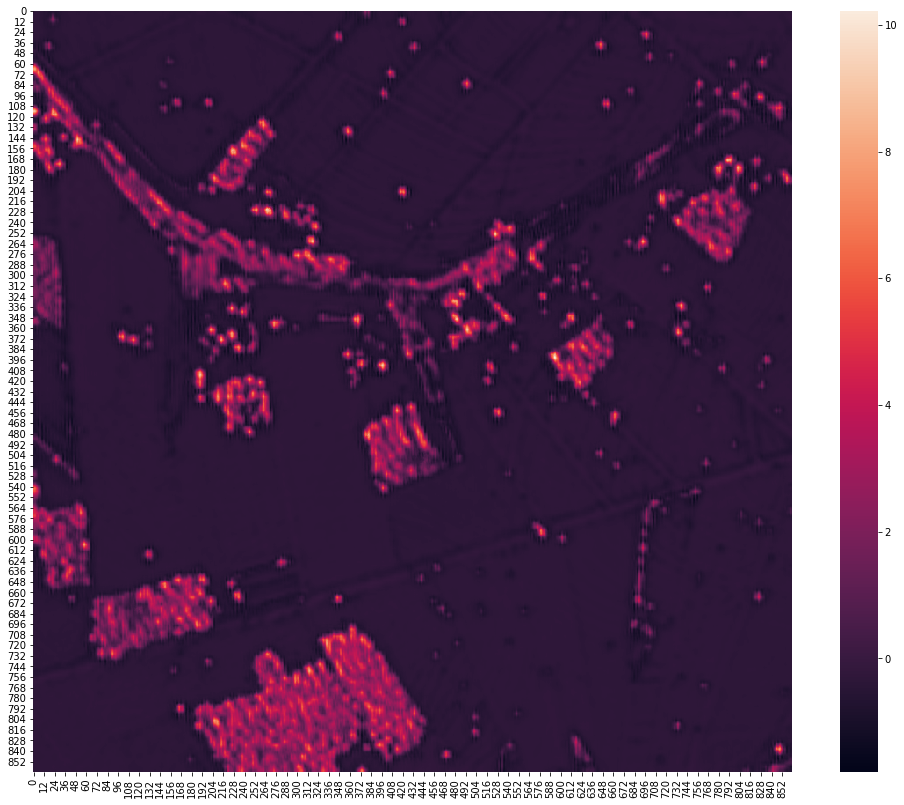

In [37]:
plt.figure(figsize=(17, 14))
sns.heatmap(y[0][0, ..., 0])

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,7.5))
from PIL import Image
from IPython.display import display


def arr_to_rgb(arr, maxes, m = True, sup = False, inpu = False):
    l = np.copy(arr)
    l_red = np.copy(l[..., 2])
    l_blue = np.copy(l[..., 0])
    l[..., 0] = l_red
    l[..., 2] = l_blue
    if m == True:
        maxes = np.array(np.max(l, axis = (0, 1)))
    l = l / maxes
    
    #if not inpu:
    #l = l[:128, :128]
    #if inpu:
    #    l = l[:64, :64]
    l = Image.fromarray((l * 255).astype(np.uint8), 'RGB')
    return l, maxes

#l, m = arr_to_rgb(output_[idx, ..., :3], None, True)
#(l.resize(( int(l.width * 6), int(l.height * 6)), 0))

In [ ]:
l, i = arr_to_rgb(y[0][0, ..., 5:8], None, True, True)
#l =l.resize(( int(l.width // 2), int(l.height // 2)), 0)
display(l.resize(( int(l.width * 3), int(l.height * 3)), 0))

In [ ]:
l, i = arr_to_rgb(y[0][0, ..., :3], None, True, True)
#l =l.resize(( int(l.width // 2), int(l.height // 2)), 0)
display(l.resize(( int(l.width * 3), int(l.height * 3)), 0))

In [ ]:
np.save("supres.npy", y)#[0])

In [ ]:
l, i = arr_to_rgb(inp_[0, ..., :3], None, True, False, True)
#l = l.resize((int(l.width * 2), int(l.height * 2)), 0)
display(l.resize(( int(l.width * 6), int(l.height * 6)), 0))

In [ ]:
meta_path = '../models/sentinel5m/' # Your .meta file
output_node_names = ['add_9:0']    # Output nodes
#output_node_names = ['conv2d_12/Sigmoid']

#with tf.Session() as sess:
    # Restore the graph
    #saver = tf.train.import_meta_graph(meta_path + "model.meta")

    # Load weights
    #saver.restore(sess,tf.train.latest_checkpoint(meta_path))
    #output_node_names = [n.name for n in tf.get_default_graph().as_graph_def().node]
    #print(output_node_names)
    
    # Freeze the graph
frozen_graph_def = tf.graph_util.convert_variables_to_constants(
    sess,
    sess.graph_def,
    output_node_names)

# Save the frozen graph
with open('../models/sentinel5m/predict_graph.pb', 'wb') as f:
    f.write(frozen_graph_def.SerializeToString())

In [ ]:
output_node_names = [n.name for n in tf.get_default_graph().as_graph_def().node]

In [ ]:
[x for x in output_node_names if 'output' in x]